In [1]:
import numpy as np
from tkinter import *
from enum import Enum
from time import sleep
from collections import deque
import matplotlib.pyplot as plt

In [41]:
T = 15 # time limit
map_width = 6
map_height = 5
map_size = (map_width, map_height)
our_pos_zero = (0,0)
his_pos_zero = (4,4)
exit_pos = (4,4)
stayStill = False

In [3]:
class Step(Enum):
    NONE = (0,0)
    LEFT = (-1,0)
    UP = (0,-1)
    RIGHT = (1,0)
    DOWN = (0,1)

In [4]:
class Direction(Enum):
    NONE = 0
    LEFT = 1
    UP = 2
    RIGHT = 3
    DOWN = 4
    
    @classmethod
    def inverse(cls, direction):
        if direction is cls.NONE:
            return cls.NONE
        if direction is cls.LEFT:
            return cls.RIGHT
        if direction is cls.UP:
            return cls.DOWN
        if direction is cls.RIGHT:
            return cls.LEFT
        if direction is cls.DOWN:
            return cls.UP

In [5]:
def in_map(pos):
    if (pos[0] < 0 or pos[1] < 0 or pos[0] >= map_width or pos[1] >= map_height):
        return False
    return True

In [7]:
# Our partial state (without the minotaur)
class PartialState:
    
    def __init__(self, pos):
        self.pos = pos # (x, y) tuple
        
    def getActions(self):
        walls_dirs = walls.get(self.pos, [])
        return [item for it in Direction if it not in walls_dirs and in_map(PartialState.step(self.pos, it))]
    
    def act(self, direction):
        # Validity check
        if direction not in getActions():
            raise Exception("Illegal action!")
        self.pos = PartialState.step(self.pos, direction)
    
    @classmethod
    def step(cls, pos, direction):
        if direction is Direction.NONE:
            return (pos[0], pos[1])
        if direction is Direction.LEFT:
            return (pos[0]-1, pos[1])
        if direction is Direction.UP:
            return (pos[0], pos[1]-1)
        if direction is Direction.RIGHT:
            return (pos[0]+1, pos[1])
        return (pos[0], pos[1]+1)
    
    @classmethod
    def getActions(cls, pos, walls, minotaur):
        walls_dirs = walls.get(pos, [])
        return [dr for dr in Direction if dr not in walls_dirs and in_map(PartialState.step(pos, dr)) and 
               ((not minotaur) or (dr is not Direction.NONE) or stayStill)]
    

## Defining walls

In [8]:
# One-way walls
walls = { (1,0): [Direction.RIGHT], (1,1): [Direction.RIGHT], (1,2): [Direction.RIGHT],
        (3,1): [Direction.RIGHT], (3,2): [Direction.RIGHT],
        (4,1): [Direction.DOWN], (5,1): [Direction.DOWN],
        (1,3): [Direction.DOWN], (2,3): [Direction.DOWN], (3,3): [Direction.DOWN], (4,3): [Direction.DOWN],
        (3,4): [Direction.RIGHT] }

# New values are appended to the first (base) dictionary
def append_to_dict(base_dict, new_vals):
    for key,vals in new_vals.items():
        base_vals = base_dict.get(key, None)
        if base_vals is None:
            base_vals = []
            base_dict[key] = base_vals
        base_vals.extend(vals)

# Mirroring the walls
mirror_walls = {}
for key,vals in walls.items():
    for val in vals:
        mirror_pos = PartialState.step(key, val)
        mirror_vals = mirror_walls.get(mirror_pos, None)
        if mirror_vals is None:
            mirror_vals = []
            mirror_walls[mirror_pos] = mirror_vals
        mirror_vals.append(Direction.inverse(val))
append_to_dict(walls, mirror_walls)

## Main algorithm

In [9]:
time_left = 30
state_space_size = (time_left, *map_size, *map_size)
V = np.zeros(state_space_size)
theta = 1e-6
delta = 1
it_count = 0

In [10]:
while delta > theta:
    delta = 0.0
    it_count += 1
    for t_left, our_x, our_y, his_x, his_y in np.ndindex(state_space_size):
        our_pos = (our_x, our_y)
        his_pos = (his_x, his_y)
        s = (t_left, *our_pos, *his_pos)
        v = V[s]
        if t_left == 0 and our_pos != exit_pos:
            V[s] = -1 # Ran out of time
        elif our_pos == his_pos:
            V[s] = -1 # Eaten
        elif our_pos == exit_pos:
            V[s] = 1 # Made it
        else:
            his_pos_new = [PartialState.step(his_pos, act) for act in PartialState.getActions(his_pos, walls, True)]
            p = 1/len(his_pos_new)
            best_act_value = -np.infty
            for direction in PartialState.getActions(our_pos, walls, False):
                our_pos_new = PartialState.step(our_pos, direction)
                new_val = np.sum([V[(t_left-1, *our_pos_new, *his_p)] for his_p in his_pos_new]) * p
                if (new_val > best_act_value):
                    best_act_value = new_val
            V[s] = best_act_value
        new_delta = np.abs(v - V[s])
        if new_delta > delta:
            delta = new_delta

## Visualization

In [12]:
class Cell():
    FILLED_COLOR_BG = "green"
    EMPTY_COLOR_BG = "white"
    FILLED_COLOR_BORDER = "green"
    EMPTY_COLOR_BORDER = "black"

    def __init__(self, master, x, y, size, fill="white", outline="black"):
        """ Constructor of the object called by Cell(...) """
        self.master = master
        self.abs = x
        self.ord = y
        self.size= size
        self.fill= fill
        self.outline=outline

    def _switch(self):
        """ Switch if the cell is filled or not. """
        self.fill= not self.fill

    def draw(self, arrow=None):
        """ order to the cell to draw its representation on the canvas """
        if self.master != None :
            fill = self.fill
            outline = self.outline
            
            xmin = self.abs * self.size
            xmax = xmin + self.size
            ymin = self.ord * self.size
            ymax = ymin + self.size
            xave = (xmin+xmax)/2
            yave = (ymin+ymax)/2

            self.master.create_rectangle(xmin, ymin, xmax, ymax, fill = fill, outline = outline)
            
            if arrow is not None:
                if arrow is Direction.NONE:
                    self.master.create_rectangle(xave-2, yave-2, xave+2, yave+2, fill = "black")
                if arrow is Direction.LEFT:
                    self.master.create_line((xmax+xave)/2, yave, (xmin+xave)/2, yave, arrow=LAST)
                if arrow is Direction.UP:
                    self.master.create_line(xave, (ymax+yave)/2, xave, (ymin+yave)/2, arrow=LAST)
                if arrow is Direction.RIGHT:
                    self.master.create_line((xmin+xave)/2, yave, (xmax+xave)/2, yave, arrow=LAST)
                if arrow is Direction.DOWN:
                    self.master.create_line(xave, (ymin+yave)/2, xave, (ymax+yave)/2, arrow=LAST)

class CellGrid(Canvas):
    def __init__(self, master, rowNumber, columnNumber, cellSize, our_position, his_position, walls, time_left, step_func, *args, **kwargs):
        Canvas.__init__(self, master, width = cellSize * columnNumber , height = cellSize * rowNumber, *args, **kwargs)

        self.cellSize = cellSize
        self.grid = []
        for row in range(rowNumber):
            line = []
            for column in range(columnNumber):
                line.append(Cell(self, column, row, cellSize))
            self.grid.append(line)
        
        self.our_position = our_position
        self.his_position = his_position
        self.walls = walls
        self.time_left = time_left
        self.bind("<Button-1>", self.handleMouseClickStep)
        self.draw()
        self.finished = False
        self.step_func = step_func
        
        #self.visualizePolicy()

    def visualizePolicy(self):
        for our_x, our_y in np.ndindex(map_size):
            self.our_position = (our_x, our_y)
            best_dir = None
            best_val = -np.infty
            his_pos_new = [PartialState.step(self.his_position, act) for act in PartialState.getActions(self.his_position, walls, True)]
            his_p_size = len(his_pos_new)
            for direction in PartialState.getActions(self.our_position, self.walls, False):
                our_pos_new = PartialState.step(self.our_position, direction)
                val = np.sum([V[(self.time_left-1, *our_pos_new, *his_p_new)] for his_p_new in his_pos_new])/his_p_size
                if val > best_val:
                    best_val = val
                    best_dir = direction
            Cell(self, self.our_position[0], self.our_position[1], self.cellSize).draw(best_dir)
        Cell(self, self.his_position[0], self.his_position[1], self.cellSize, "red", Cell.FILLED_COLOR_BORDER).draw()
        #self.create_line(0, 0, 200, 100, arrow=tk.LAST)
        
    def draw(self):
        for row in self.grid:
            for cell in row:
                cell.draw()
        # Drawing the players
        Cell(self, self.our_position[0], self.our_position[1], self.cellSize, "green", Cell.FILLED_COLOR_BORDER).draw()
        Cell(self, self.his_position[0], self.his_position[1], self.cellSize, "red", Cell.FILLED_COLOR_BORDER).draw()
        

    def _eventCoords(self, event):
        row = int(event.y / self.cellSize)
        column = int(event.x / self.cellSize)
        return row, column

    def handleMouseClickStep(self, event):
        if not self.finished:
            self.step_func(self)

def step(self):
    best_pos = None
    best_val = -np.infty
    his_pos_new = [PartialState.step(self.his_position, act) for act in PartialState.getActions(self.his_position, walls, True)]
    his_p_size = len(his_pos_new)
    for direction in PartialState.getActions(self.our_position, self.walls, False):
        our_pos_new = PartialState.step(self.our_position, direction)
        val = np.sum([V[(self.time_left-1, *our_pos_new, *his_p_new)] for his_p_new in his_pos_new])/his_p_size
        if val > best_val:
            best_val = val
            best_pos = our_pos_new
    self.our_position = best_pos
    self.time_left = self.time_left-1

    self.his_position = his_pos_new[np.random.choice(his_p_size)]

    self.draw()
    if self.our_position == self.his_position or self.our_position == exit_pos or self.time_left == 0:
        self.finished = True

def step_geom(self):
    best_pos = None
    best_val = -np.infty
    his_pos_new = [PartialState.step(self.his_position, act) for act in PartialState.getActions(self.his_position, walls, True)]
    his_p_size = len(his_pos_new)
    for direction in PartialState.getActions(self.our_position, self.walls, False):
        our_pos_new = PartialState.step(self.our_position, direction)
        val = np.sum([V_geom[(*our_pos_new, *his_p_new)] for his_p_new in his_pos_new])/his_p_size
        if val > best_val:
            best_val = val
            best_pos = our_pos_new
    self.our_position = best_pos
    self.his_position = his_pos_new[np.random.choice(his_p_size)]
    self.draw()
    if self.our_position == self.his_position or self.our_position == exit_pos:
        self.finished = True
            
app = Tk()
grid = CellGrid(app, map_height, map_width, 50, our_pos_zero, his_pos_zero, walls, 15, step)
grid.pack()
app.mainloop()

## Calculating the maximum probabilities

In [25]:
T = 9
s0 = (T, *our_pos_zero, *his_pos_zero, 1.0)
q = deque([s0])
p_exiting = 0
while (len(q) != 0):
    s = q.pop()
    t_left,our_pos,his_pos,p = s[0], (s[1], s[2]), (s[3], s[4]), s[5]
    
    if our_pos == exit_pos and our_pos != his_pos:
        p_exiting += p # Made it
        continue
    elif t_left == 0 or our_pos == his_pos:
        continue
    
    best_pos = None
    best_val = -np.infty
    his_pos_new = [PartialState.step(his_pos, act) for act in PartialState.getActions(his_pos, walls, True)]
    his_p_size = len(his_pos_new)
    for direction in PartialState.getActions(our_pos, walls, False):
        our_pos_new = PartialState.step(our_pos, direction)
        val = np.sum([V[(t_left-1, *our_pos_new, *his_p_new)] for his_p_new in his_pos_new])/his_p_size
        if val > best_val:
            best_val = val
            best_pos = our_pos_new
    for his_p_new in his_pos_new:
        q.append((t_left-1, *best_pos, *his_p_new, p/his_p_size))

In [ ]:
# 15: 1.0
# 14: 1.0
# 13: 1.0
# 12: 1.0
# 11: 1.0
# 10: 0.13458076131
# 9: 0
# 8: 0


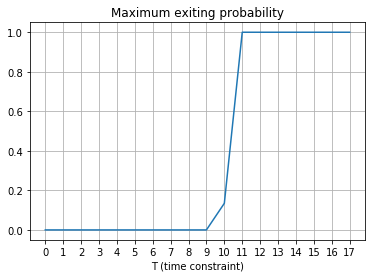

In [27]:
x = np.arange(18)
#p_exit = [0,0,0,0,0,0,0,0,0,0,
#          0.440500937044526, # 10
#          0.5420765817899836, # 11
#          0.5868840042438842, # 12
#          0.6177752052531786, # 13
#          0.6464099708489832, # 14
#          0.6740127245201469, # 15
#          0.700994434219172, # 16
#          0.7260719642171201 # 17
#         ]
p_exit = [0,0,0,0,0,0,0,0,0,0,
          0.13458076131, # 10
          1.0, # 11
          1.0, # 12
          1.0, # 13
          1.0, # 14
          1.0, # 15
          1.0, # 16
          1.0 # 17
         ]
plt.plot(x, p_exit)
plt.xlabel('T (time constraint)')
plt.xticks(np.arange(18))
#plt.ylabel('probability of exiting')
plt.title('Maximum exiting probability')
plt.grid(True)
plt.savefig("max_probs_2.png")
#plt.show()

## The geometrical thing

In [42]:
state_space_size = (*map_size, *map_size)
V_geom = np.zeros(state_space_size)
theta = 1e-6
delta = 1
it_count = 0
gamma = 1-(1/30)
r_step = 0
r_killed = 0
r_exit = 1

In [43]:
while delta > theta:
    delta = 0.0
    it_count += 1
    for our_x, our_y, his_x, his_y in np.ndindex(state_space_size):
        our_pos = (our_x, our_y)
        his_pos = (his_x, his_y)
        s = (*our_pos, *his_pos)
        v = V_geom[s]
        if our_pos == his_pos:
            V_geom[s] = r_killed # Eaten
        elif our_pos == exit_pos:
            V_geom[s] = r_exit # Made it
        else:
            his_pos_new = [PartialState.step(his_pos, act) for act in PartialState.getActions(his_pos, walls, True)]
            p = 1/len(his_pos_new)
            best_act_value = -np.infty
            for direction in PartialState.getActions(our_pos, walls, False):
                our_pos_new = PartialState.step(our_pos, direction)
                new_val = np.sum([r_step + gamma*V_geom[(*our_pos_new, *his_p)] for his_p in his_pos_new]) * p
                if (new_val > best_act_value):
                    best_act_value = new_val
            V_geom[s] = best_act_value
        new_delta = np.abs(v - V_geom[s])
        if new_delta > delta:
            delta = new_delta

In [44]:
class Simulator():
    
    def __init__(self):
        self.walls = walls
        self.p_geom = 1/30
        self.V = V_geom
        
    def step(self):
        best_pos = None
        best_val = -np.infty
        his_pos_new = [PartialState.step(self.his_position, act) for act in PartialState.getActions(self.his_position, walls, True)]
        his_p_size = len(his_pos_new)
        for direction in PartialState.getActions(self.our_position, self.walls, False):
            our_pos_new = PartialState.step(self.our_position, direction)
            val = np.sum([self.V[(*our_pos_new, *his_p_new)] for his_p_new in his_pos_new])/his_p_size
            if val > best_val:
                best_val = val
                best_pos = our_pos_new
        self.our_position = best_pos
        self.his_position = his_pos_new[np.random.choice(his_p_size)]
        self.time += 1
        if self.our_position == self.his_position:
            self.finished = True
            return
        if self.our_position == exit_pos:
            self.finished = True
            self.wins += 1
            self.time_ave += self.time
            return
        if np.random.sample() < self.p_geom:
            self.finished = True
        
    def simulate(self):
        self.wins = 0
        self.time_ave = 0
        self.samples_num = 10000
        for i in range(self.samples_num):
            self.finished = False
            self.our_position = our_pos_zero
            self.his_position = his_pos_zero
            self.time = 0
            while not self.finished:
                self.step()
        self.time_ave /= self.wins
    

In [45]:
sim = Simulator()
sim.simulate()

In [46]:
sim.wins

7162

In [47]:
sim.time_ave

11.0